### Starting over with the LSTM model ... but for the ellipse metrics this time. 

File created 7/31/2025. 

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

tf.compat.v1.disable_eager_execution()
#import investigate

2025-08-05 18:37:22.431761: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 18:37:22.433866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-05 18:37:22.460511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 18:37:22.460532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 18:37:22.460550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
print(tf.__version__)

2.14.1


In [3]:
#load input data, it is max/min standardized, NaNs removed
#stratospheric polar vortex ellipse diagnostics from Fernandez et al 2025 (in review)
#comparison here may be a little muddled because I am limitied in the days that I can observe, however, I am currently working(7/8/2025) on calculating the diagnostics for the full dataset
#this will be fixed. 

infile = open("../data/nolag_extendedanom_input.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

nolag_input.shape

(62, 149, 8)

In [4]:
idx = 149
#switch to 149 for normal. 

inp1 = np.empty((62,idx,8)) #create new input array, 14 day lag. 

shift = 0
#0 if normal
#this indicates setting the start date as November 2 rather than October 19

##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:62,shift:,0] ##wind
inp1[:,:,1] = nolag_input[:62,shift:,1] ##ratio
inp1[:,:,2] = nolag_input[:62,shift:,2] ##latitude
inp1[:,:,3] = nolag_input[:62,shift:,3] ##longitude
inp1[:,:,4] = nolag_input[:62,shift:,4] ##size
inp1[:,:,5] = nolag_input[:62,shift:,5] ##ephi
inp1[:,:,6] = nolag_input[:62,shift:,6] ##gph
inp1[:,:,7] = nolag_input[:62,shift:,7] ##pv

inp=inp1.reshape(62*idx,8)
inp.shape

(9238, 8)

In [5]:
#load output data file.
#I can change this to represent any of the available temp regions. 
infile = open("../data/eur_anomtemps_reduced.p","rb",)
output = pickle.load(infile) 
infile.close()

In [6]:
output.shape

(9238,)

In [7]:
#convert to pandas dataframe
input = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph','pv']
input.columns = col_names

input

,wind,rat,cenlat,cenlon,size,ephi,gph,pv
0,0.570790,0.618161,0.828871,0.055095,0.326356,0.726418,0.719386,0.126977
1,0.573147,0.626809,0.826273,0.565595,0.330771,0.733839,0.721613,0.203389
2,0.576683,0.629552,0.822728,0.707387,0.341216,0.734021,0.727079,0.232331
3,0.581320,0.621400,0.820200,0.769665,0.351285,0.743165,0.726248,0.218715
4,0.585344,0.615700,0.820122,0.801782,0.360734,0.757252,0.722180,0.208927
...,...,...,...,...,...,...,...,...
9233,0.593302,0.446485,0.741122,0.674863,0.550987,0.194401,0.583356,0.649220
9234,0.585727,0.443649,0.738294,0.688205,0.539156,0.203137,0.576748,0.704463
9235,0.581969,0.438761,0.736058,0.705501,0.522961,0.221439,0.577187,0.760367
9236,0.581262,0.432586,0.734603,0.725774,0.506165,0.259560,0.586223,0.765773


In [8]:
inp2 = input.values.reshape(62,149,8)
inp2.shape

(62, 149, 8)

In [9]:
##need to change this based on lag 
## 14-days = [:, 10:] 10 day window rather than 14
## 20-days = [:, 16:]
## 30-days = [:, 26:]

# 139
# 133
# 123

## 14-days = [:, 14:] 14 day window
## 20-days = [:, 20:]
## 30-days = [:, 30:]

# 135
# 129
# 119

lead = 135

temp = output.reshape(62, 149)
temp = temp[:, 14:]
print(temp.shape)

temp_flat = temp.flatten()

(62, 135)


In [10]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input =  np.empty((62,lead,14,8))
new_output = np.empty((62,lead))

for i in range(0,62):
    for j in range(0,lead):
        new_input[i,j,:,:] = inp2[i,j:j+14,:]
        new_output[i,j] = temp[i,j]

In [11]:
new_input = np.array(new_input)
new_output = np.array(new_output)
print(new_input.shape)
print(new_output.shape)

(62, 135, 14, 8)
(62, 135)


In [12]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)
frac_end

7114

In [13]:
frac_ind

1256

In [14]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input.reshape((62*lead),14,8))
Y_all = np.copy(new_output.flatten())

##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [15]:
Y_all.shape

(8370, 2)

In [16]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [17]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [18]:
##number of input nodes
numb_int = X_all.shape[1:]

##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test = X_tes
Y_test = Y_tes

In [19]:
Y_train.shape

(5858, 2)

In [20]:
numb_int

(14, 8)

### Model Architecture. 

In [21]:
######
batch_size = 64 #The number of samples the network sees before it backpropagates (batch size)
epochs = 30 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [22]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [23]:
#model
def basic_LSTM(ntimestep, nfeature, n1, n2, n3, rl1, rl2, rl3, lr):  
    input_tensor = Input(shape=(ntimestep, nfeature))
    
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          dropout=0.331, 
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)),
        return_sequences=True)(input_tensor)
       
    layer2 = layers.RNN(
        layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl2)),
        return_sequences=False)(layer1)
    
    layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer2)

    output_tensor = layers.Dense(2, activation='softmax',)(layer3)

    model = Model(input_tensor, output_tensor)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    loss = 'categorical_crossentropy' #categorical_focal_loss(alpha=0.7, gamma=0.5)
    #decay_rate = lr / epochs
    #momentum = 0.9

    model.compile(optimizer=opt,loss=loss,metrics=[keras.metrics.categorical_accuracy],)
                            
    return model

In [24]:
tf.keras.backend.clear_session()

In [25]:
#model = basic_LSTM(numb_int[0],numb_int[1], 64, 4, 32, 0.651, 0.681, 0.041, 0.092134)
model = basic_LSTM(numb_int[0],numb_int[1], 128, 14, 28, 0.03, 0.03, 0.06, 0.0009)


In [26]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.0604994}

In [27]:
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
          batch_size=batch_size, epochs=epochs, class_weight=class_weight, shuffle=shuffle)#, callbacks=[stop_early])

Train on 5858 samples, validate on 1256 samples
Epoch 1/30


2025-08-05 18:37:24.484920: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2025-08-05 18:37:24.549892: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense/bias/v/Assign' id:1313 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


5858/5858 [==============================] - 1s 223us/sample - loss: 5.0903 - categorical_accuracy: 0.5459 - val_loss: 3.7004 - val_categorical_accuracy: 0.5247
Epoch 2/30
  64/5858 [..............................] - ETA: 0s - loss: 3.7180 - categorical_accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5858/5858 [==============================] - 1s 148us/sample - loss: 3.0445 - categorical_accuracy: 0.5517 - val_loss: 2.4903 - val_categorical_accuracy: 0.5804
Epoch 3/30
5858/5858 [==============================] - 1s 143us/sample - loss: 2.1910 - categorical_accuracy: 0.5626 - val_loss: 1.8801 - val_categorical_accuracy: 0.6091
Epoch 4/30
5858/5858 [==============================] - 1s 143us/sample - loss: 1.7075 - categorical_accuracy: 0.5685 - val_loss: 1.5160 - val_categorical_accuracy: 0.5422
Epoch 5/30
5858/5858 [==============================] - 1s 143us/sample - loss: 1.3911 - categorical_accuracy: 0.5577 - val_loss: 1.2487 - val_categorical_accuracy: 0.5478
Epoch 6/30
5858/5858 [==============================] - 1s 143us/sample - loss: 1.1726 - categorical_accuracy: 0.5498 - val_loss: 1.0555 - val_categorical_accuracy: 0.5987
Epoch 7/30
5858/5858 [==============================] - 1s 144us/sample - loss: 1.0149 - categorical_accuracy: 0.5700 - val_loss: 0.9398 - val_categori

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-08-05 18:37:50.353740: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Softmax' id:737 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

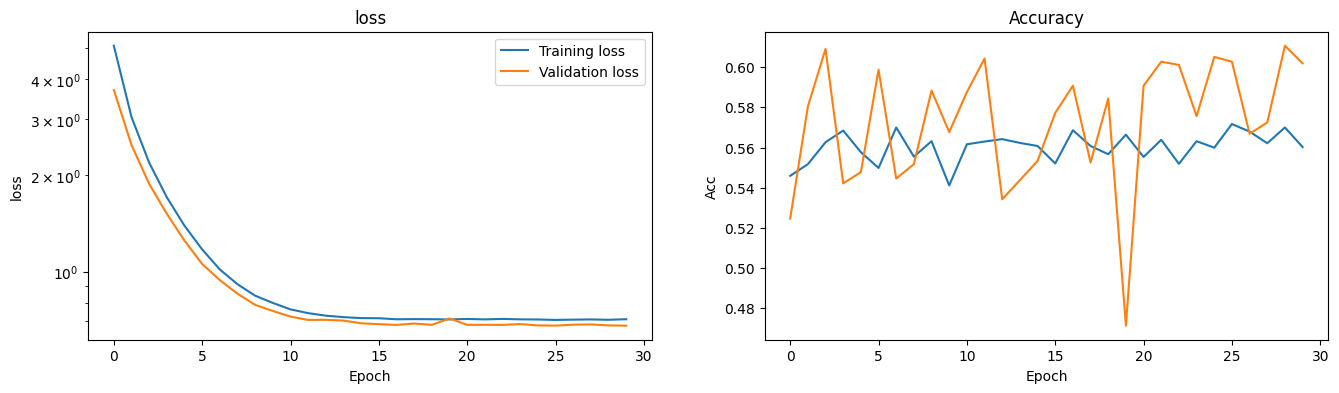

In [28]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend
#plt.savefig("SEUS_onearch.png")

In [29]:
from sklearn.metrics import classification_report
import numpy as np

y_val_pred = model.predict(X_validation)
y_val_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(Y_validation, axis=1)

print(classification_report(y_val_true, y_val_classes, digits=3))

              precision    recall  f1-score   support

           0      0.602     0.794     0.685       684
           1      0.602     0.372     0.460       572

    accuracy                          0.602      1256
   macro avg      0.602     0.583     0.572      1256
weighted avg      0.602     0.602     0.582      1256



In [30]:
# Convert one-hot labels to 1D integer labels (0 or 1)
y_true = np.argmax(Y_test, axis=1)

# Extract predicted probability for the positive class (class 1)
y_prob = pred_test[:,1]

# Create climatology baseline: constant probability = mean positive class rate
p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)

# Compute Brier Scores
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)

# Compute Brier Skill Score
bss = 1 - (bs_model / bs_climo)

print(f"Brier Score (Model): {bs_model:.4f}")
print(f"Brier Score (Climatology): {bs_climo:.4f}")
print(f"Brier Skill Score: {bss:.4f}")

Brier Score (Model): 0.2382
Brier Score (Climatology): 0.2500
Brier Skill Score: 0.0473


In [31]:
## Labels for negative class
y_true_neg = 1 - y_true  # flip 0 <-> 1

# Predicted probabilities for negative class
y_prob_neg = pred_test[:, 0]

# Calculate Brier Score and BSS for negative class
bs_model_neg = brier_score_loss(y_true_neg, y_prob_neg)
bs_climo_neg = brier_score_loss(y_true_neg, np.full_like(y_true_neg, y_true_neg.mean()))
bss_neg = 1 - (bs_model_neg / bs_climo_neg)

print(f"Brier Score (Model): {bs_model_neg:.4f}")
print(f"Brier Score (Climatology): {bs_climo_neg:.4f}")
print(f"Brier Skill Score: {bss_neg:.4f}")

Brier Score (Model): 0.2382
Brier Score (Climatology): 0.4992
Brier Skill Score: 0.5229


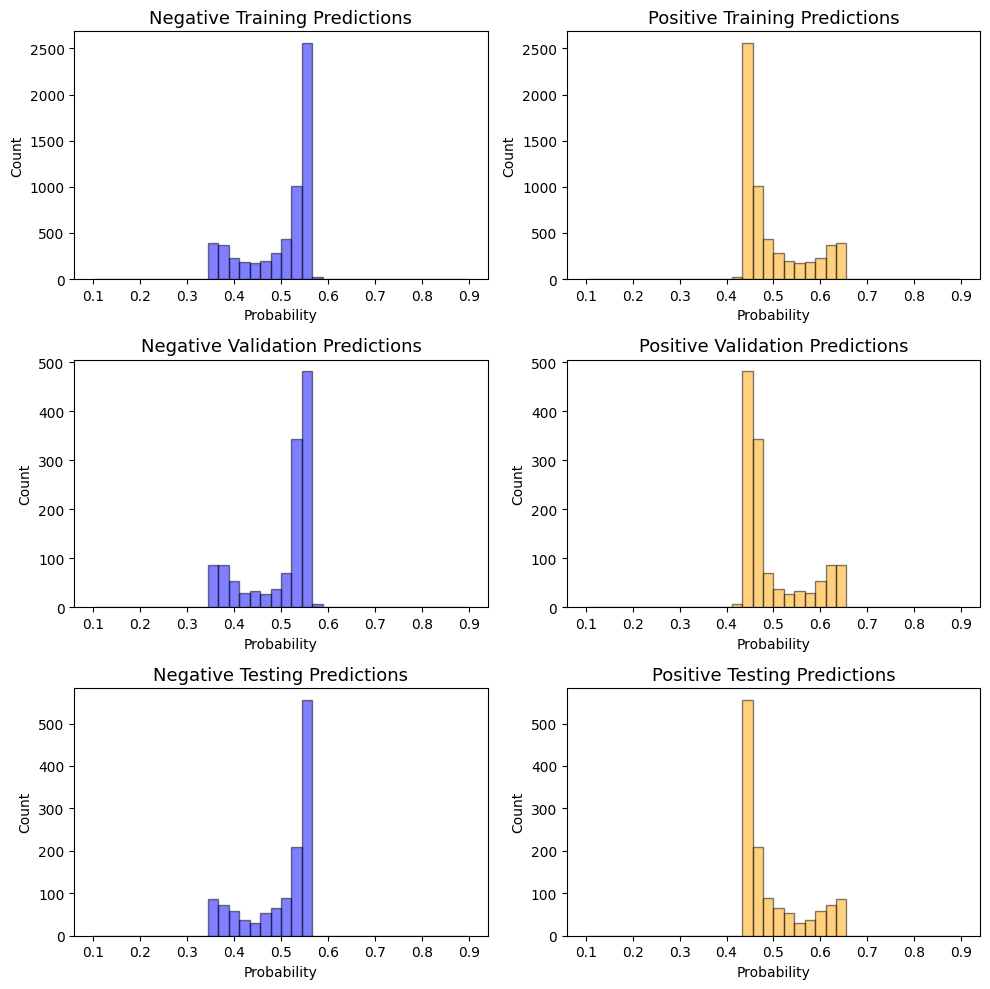

In [32]:
bins = np.linspace(0.1, 0.9, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(pred_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(pred_test[:,1], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(pred_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(pred_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(pred_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(pred_val[:,1], bins=bins)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Negative Validation Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax4.set_title('Positive Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax5.set_title('Negative Testing Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Positive Testing Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

plt.tight_layout()

### Try SHAP.

In [33]:
##testing shap
import shap
import pylab
import random

In [34]:
#random range of dates from X_train for explainer
start = random.randrange(len(X_train[:,0])-frac_ind)
end = start+(frac_ind)

In [35]:
print(start)

4534


In [36]:
#use gradient explainer on subset of training data
sample = X_train[start:end]
explainer = shap.GradientExplainer(model, sample)

In [37]:
#use explainer
shap_values = explainer.shap_values(X_train[:100])

2025-08-05 18:37:53.534665: W tensorflow/c/c_api.cc:305] Operation '{name:'rnn/while' id:341 op device:{requested: '', assigned: ''} def:{{{node rnn/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT]{attr_hash=5510909326915687547}, _lower_using_switch_merge=true, _num_original_outputs=82, _read_only_resource_inputs=[9, 10, 11], body=rnn_while_body_281_rewritten[], cond=rnn_while_cond_280_rewritten[], output_shapes=[[], [], [], [], [?,128], ..., [], [], [], [], []]{attr_hash=3975627848203976108}, parallel_iterations=32](rnn/while/loop_counter, rnn/while/maximum_iterations, rnn/time, rnn/TensorArrayV2_1, rnn/zeros, rnn/zeros_1, rnn/strided_slice_1, rnn/TensorArrayUnstack/TensorListFromTensor, keras_learning_phase, rnn/lstm_cell/kernel, rnn/lstm_cell/recurrent_kernel, rnn/lstm_cell/bias, rnn/while/EmptyTensorList, rnn/while/EmptyTensorList_1, rnn/while/EmptyTensorList_2, rnn/while/EmptyTensorList_3, rnn/w

In [38]:
#change shap values to array
shap_values = np.array(shap_values)
shap_values.shape

(2, 100, 14, 8)

In [39]:
aggs = np.abs(shap_values) ##aggregate over the samples to make all positive
aggs.shape

(2, 100, 14, 8)

In [40]:
#take mean along sample dimension
aggs = aggs.mean(axis=1)
aggs.shape

(2, 14, 8)

In [41]:
feat_cat = aggs.mean(axis=1) ##take mean along timestep axis
feat_cat.shape
feat_cat_df = pd.DataFrame(feat_cat) #turn into pandas dataframe

In [42]:
feat_cat.shape

(2, 8)

In [43]:
#fetures = ['1', '56', '0', '54', '9', '57', '2', '31', '26', '14','20', '6', '11', '38', '21', '18', '15', '22', '12', '13']

#labels for columns
features = ['wind','rat','cenlat','cenlon','size','ephi','gph','pv']

In [44]:
#add labels and transpose model
feat_cat_df.columns = features
featcat_df = feat_cat_df.T

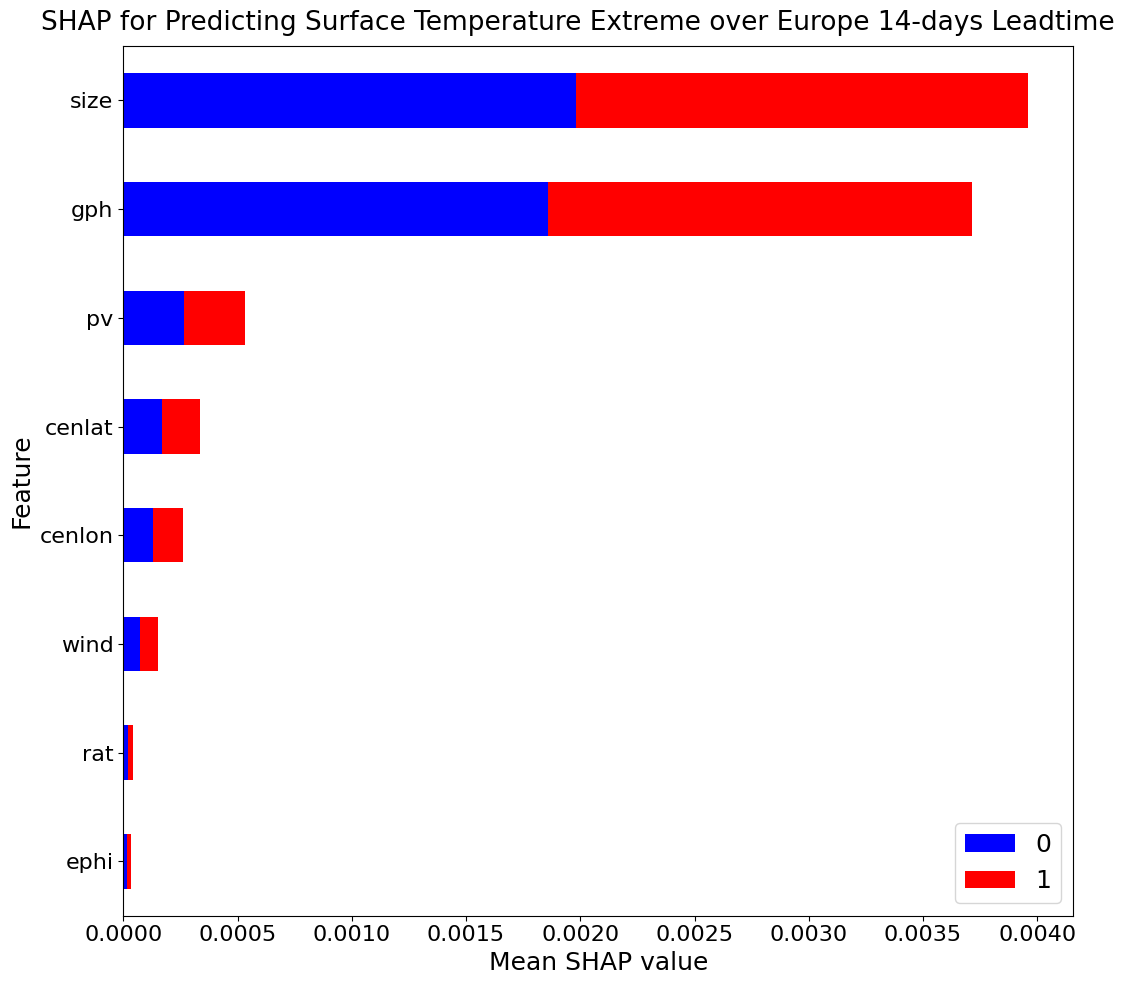

In [45]:
fig = plt.figure(figsize=(11,10),dpi=100)
fig.suptitle("SHAP for Predicting Surface Temperature Extreme over Europe 14-days Leadtime",
             fontsize = 19,x=.53) 
 
ax1 = fig.add_subplot(1,1,1)
featcat_df.loc[featcat_df.sum(1).sort_values(ascending=True).index[:]].plot(
    kind="barh", stacked=True, ax = ax1, colormap = 'bwr')
ax1.tick_params(axis='both', which='major', labelsize= 16)
#ax1.set_yticks([0,1,2,3,4,5,6,7,8],feature_name_bh)
ax1.set_xlabel('Mean SHAP value', fontsize =18 )
ax1.set_ylabel('Feature', fontsize =18 )
ax1.legend(loc = 'lower right', fontsize =18)
#ax1.set_xlim(0,0.25)

plt.tight_layout()
plt.savefig('practice_SHAP.png')

In [46]:
#stuff for creating beeswarm plots
shap_class1_agg = np.mean(shap_values[1], axis=1)  #pos class agg shap values (samples, features)
shap_class0_agg = np.mean(shap_values[0], axis=1)  #neg class agg shap values (samples, features)
X_sample = np.mean(X_train[:100], axis=1) #reference from training for agg shaps(samples, features)

In [47]:
shap_class1_agg.shape

(100, 8)

In [48]:
#separate reference dataframe with column names. 
X_df = pd.DataFrame(X_sample, columns=features)

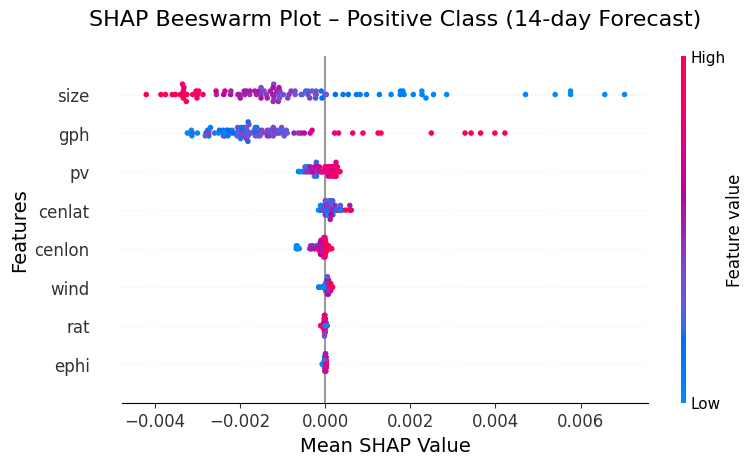

In [49]:
shap.summary_plot(shap_class1_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Beeswarm Plot – Positive Class (14-day Forecast)", fontsize=16)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("beeswarm_postest.png")
plt.show()

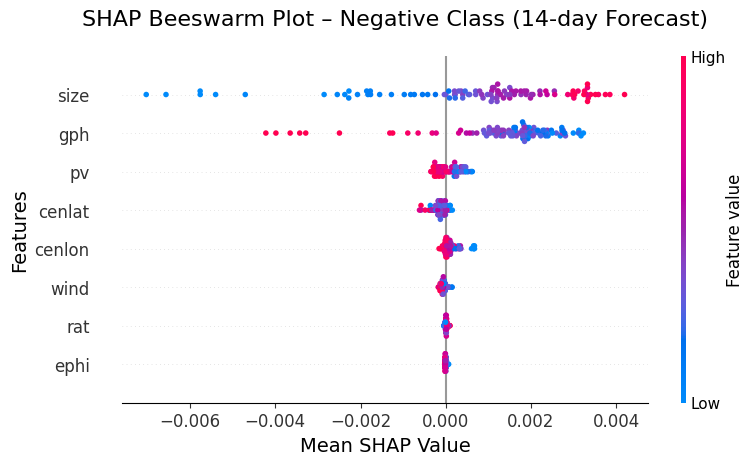

In [50]:
shap.summary_plot(shap_class0_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Beeswarm Plot – Negative Class (14-day Forecast)", fontsize=16)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("beeswarm_negtest.png")
plt.show()